In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0, state = None):
        outputs = []
        #print(input.shape)
        #print(input.size(0))
        #if state is None:
        if True:
            h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
            c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
            h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
            c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        else: 
            h_t, c_t, h_t2, c_t2 = state[0], state[1], state[2], state[3]
        #print(input.shape) # (1, 999)
        '''for input_t in input[0]:
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]'''
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            #print('input_t: ', input_t.shape)
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            #print('h_t: ', h_t.shape)
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            #print(output.shape)
            outputs += [output]
        #print('input: ', input.shape)
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            print(h_t.shape)
            print(c_t.shape)
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            #print(output.shape)
            outputs += [output]
        #print(outputs.shape)
        outputs = torch.stack(outputs, 1).squeeze(2)
        #print(outputs.shape)
        h_state = [h_t, c_t, h_t2, c_t2]
        return outputs, h_state

In [3]:
class LSTM_RNN(nn.Module):
    def __init__(self):
        super(LSTM_RNN, self).__init__()
        self.hidden_size = 51
        self.batch_size = 1
        self.num_layer = 1
        self.in_size = 20
        self.out_size = 20
        IN_DIM = 1
        
        # Input shape:  torch.Size([1, 1, 2])
        # Input shape:  torch.Size([6, 1, 2])
        self.hidden_x = self.init_hidden()
        self.hidden_y = self.init_hidden()
        self.lstm = nn.LSTM(IN_DIM, self.hidden_size) # IN_DIM, OUT_DIM
        self.linear1 = nn.Linear(20, 100)
        self.linear2 = nn.Linear(20, 100)
        self.linear3 = nn.Linear(200, 50)
        self.linear_x = nn.Linear(51, 1)
        self.linear_y = nn.Linear(51, 1)

    def forward(self, input_x, input_y):        
        '''out, self.hidden = self.lstm(input, self.hidden)
        d_len = int(len(input)/2)
        for i in range(d_len):
            data = input[i:i+d_len]'''
        out_x = []
        out_y = []
        for i in range(len(input_x)):
            x = input_x[i].view(1, 1, -1)
            y = input_y[i].view(1, 1, -1)
            state_x, self.hidden_x = self.lstm(x, self.hidden_x)
            state_y, self.hidden_y = self.lstm(y, self.hidden_y)
            predict_x = self.linear_x(state_x)
            predict_y = self.linear_y(state_y)
            out_x += [predict_x]
            out_y += [predict_y]
            
        #print(state_x.shape, state_y.shape) #[1,1,51]
        #state_x = state_x.view(1, -1)
        #state_y = state_y.view(1, -1)
        #print(state_x.shape, state_y.shape) #[51]
        #lstm_cat = torch.cat((state_x, state_y), dim=0)
        #print(lstm_cat.shape) #[102]
        for i in range(len(input_x)-1):
            state_x, self.hidden_x = self.lstm(predict_x, self.hidden_x)
            state_y, self.hidden_y = self.lstm(predict_y, self.hidden_y)
            predict_x = self.linear_x(state_x)
            predict_y = self.linear_y(state_y)
            out_x += [predict_x]
            out_y += [predict_y]
            
        out_x = torch.stack(out_x, 1).squeeze(2)
        out_y = torch.stack(out_y, 1).squeeze(2)
        return out_x, out_y
    
    def init_hidden(self):
        hidden = (torch.randn(self.num_layer, self.batch_size, self.hidden_size), \
                  torch.randn(self.num_layer, self.batch_size, self.hidden_size))
        return hidden

In [4]:
class LINEAR_NET(nn.Module):
    def __init__(self):
        super(LINEAR_NET, self).__init__()
        self.hidden_size = 51
        self.batch_size = 1
        self.num_layer = 1
        self.in_size = 20
        self.out_size = 20
        IN_DIM = 2
        
        # Input shape:  torch.Size([1, 1, 2])
        # Input shape:  torch.Size([6, 1, 2])
        self.hidden = self.init_hidden()
        self.lstm = nn.LSTM(IN_DIM, self.hidden_size) # IN_DIM, OUT_DIM
        self.linear1 = nn.Linear(20, 100)
        self.linear2 = nn.Linear(20, 100)
        self.linear3 = nn.Linear(200, 50)
        self.linear_x = nn.Linear(50, self.out_size)
        self.linear_y = nn.Linear(50, self.out_size)

    def forward(self, input_x, input_y):        
        '''out, self.hidden = self.lstm(input, self.hidden)
        d_len = int(len(input)/2)
        for i in range(d_len):
            data = input[i:i+d_len]'''
        in_x = self.linear1(input_x)
        in_y = self.linear2(input_y)
        #print(in_x.shape, in_y.shape)
        fc1 = torch.cat((in_x, in_y), dim=0)
        fc2 = self.linear3(fc1)
        x = self.linear_x(fc2)
        y = self.linear_y(fc2)
        return [x, y]
    
    def init_hidden(self):
        hidden = (torch.randn(self.num_layer, self.batch_size, self.hidden_size), \
                  torch.randn(self.num_layer, self.batch_size, self.hidden_size))
        return hidden

In [5]:
# build the model
seq = Sequence()
#seq.load_state_dict(torch.load('seq.pth'))
seq.double()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
#optimizer = torch.optim.Adam(seq.parameters(), lr=0.005)
#begin to train
old_state = None
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

In [6]:
# build the model
seq = LINEAR_NET()
#seq.load_state_dict(torch.load('seq.pth'))
seq.float()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
#optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
optimizer = torch.optim.Adam(seq.parameters(), lr=0.005)
#begin to train
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

In [7]:
# build the model
seq = LSTM_RNN()
#seq.load_state_dict(torch.load('seq.pth'))
seq.float()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
#optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
optimizer = torch.optim.Adam(seq.parameters(), lr=0.001)
#begin to train
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

In [8]:
def create_sin_pt():
    # load data and make training set
    data = torch.load('traindata.pt')
    data = data[0][:]
    data = np.expand_dims(data, axis=0)
    print(data.shape)
    input = torch.from_numpy(data[:, :-1])
    #print(input.shape)
    target = torch.from_numpy(data[:, 1:])
    test_input = torch.from_numpy(data[:, :-1])
    print('test_input: ', test_input.shape)
    test_target = torch.from_numpy(data[:, 1:])
    return data, input, target, test_input, test_target

In [9]:
def create_linear():
    step = 5
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(0, 100, 1000, dtype=np.double)
    #x_np = np.sin(steps)    # float32 for converting torch FloatTensor
    x_np = steps
    data = np.expand_dims(x_np, axis=0)
    input = torch.from_numpy(data[:, :-1])
    #print(input.shape)
    target = torch.from_numpy(data[:, 1:])
    test_input = torch.from_numpy(data[:, :-1])
    test_target = torch.from_numpy(data[:, 1:])
    print('test_input: ', test_input.shape)
    plt.plot(steps, x_np, 'b-', label='input (sin)')
    plt.legend(loc='best')
    plt.show()
    return data, input, target, test_input, test_target

In [10]:
def create_sin():
    step = 5
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(0, 100, 1000, dtype=np.double)
    x_np = np.sin(steps)    # float32 for converting torch FloatTensor
    #x_np = steps
    data = np.expand_dims(x_np, axis=0)
    input = torch.from_numpy(data[:, :-1])
    #print(input.shape)
    target = torch.from_numpy(data[:, 1:])
    test_input = torch.from_numpy(data[:, :-1])
    test_target = torch.from_numpy(data[:, 1:])
    print('test_input: ', test_input.shape)
    plt.plot(steps, x_np, 'b-', label='input (sin)')
    plt.legend(loc='best')
    plt.show()
    return data, input, target, test_input, test_target

test_input:  torch.Size([1, 999])


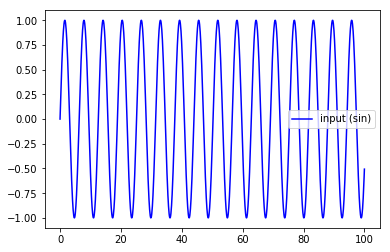

In [11]:
data, input, target, test_input, test_target = create_sin()

Number of position:  80
torch.Size([20])


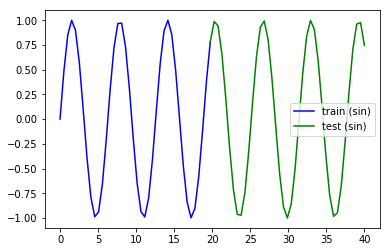

In [12]:
X_LEN = 40
P_NUM = 80
# (x, y, z) ==> (x~y)/z
x_np = np.linspace(0, X_LEN, P_NUM, dtype=np.double)
y_np = np.linspace(0, X_LEN, P_NUM, dtype=np.double)
y_np = np.sin(y_np)    # float32 for converting torch FloatTensor
positions = []
for i in range(P_NUM):
    noise = np.random.rand(1, 1)[0][0]/2.
    positions.append([x_np[i], y_np[i]])
print('Number of position: ', len(positions))


input_x = []
input_y = []
for i in positions[0:20]:
    input_x.append(i[0])
    input_y.append(i[1])
input_x = torch.tensor(input_x)
input_y = torch.tensor(input_y)

target_x = []
target_y = []
for i in positions[20:40]:
    target_x.append(i[0])
    target_y.append(i[1])
target_x = torch.tensor(target_x)
target_y = torch.tensor(target_y)

test_input_x = []
test_input_y = []
for i in positions[40:60]:
    test_input_x.append(i[0])
    test_input_y.append(i[1])
test_input_x = torch.tensor(input_x)
test_input_y = torch.tensor(input_y)
test_target_x = []
test_target_y = []
for i in positions[60:80]:
    test_target_x.append(i[0])
    test_target_y.append(i[1])
test_target_x = torch.tensor(test_target_x)
test_target_y = torch.tensor(test_target_y)

#input = torch.tensor(positions[0:20]).double()
#target = torch.tensor(positions[20:40]).double()
#test_input = torch.tensor(positions[40:60]).double()
#test_target = torch.tensor(positions[60:80]).double()

p_x = []
p_y = []
for i in positions:
    p_x.append(i[0])
    p_y.append(i[1])
print(input_x.shape)
plt.plot(p_x[:40], p_y[:40], 'b-', label='train (sin)')
plt.plot(p_x[39:], p_y[39:], 'g-', label='test (sin)')

plt.legend(loc='best')
plt.show()

test loss: 68.68549346923828


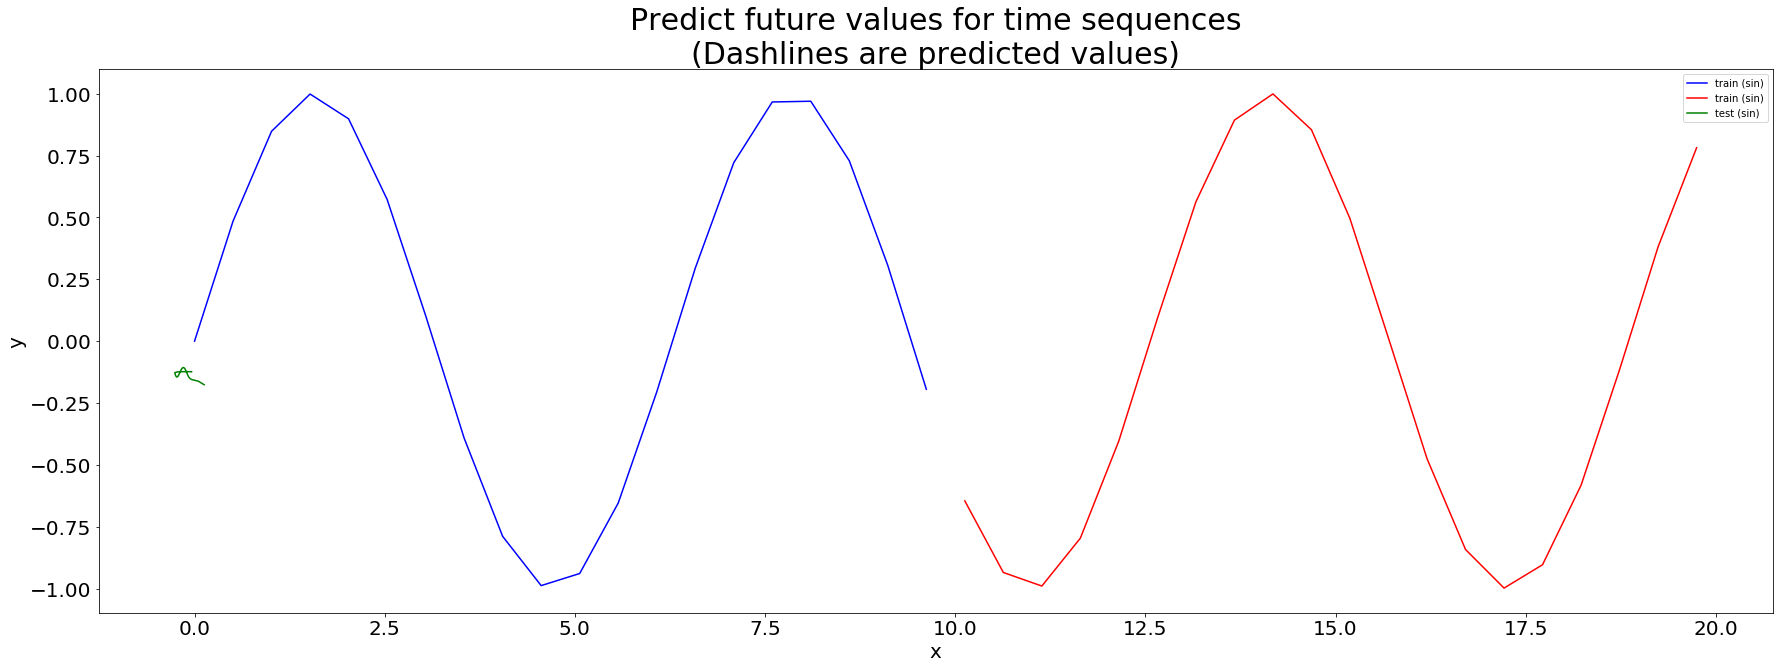

In [13]:
def show_model_lstm():
    with torch.no_grad():
        predict_x, predict_y = seq(input_x, input_y)
        predict_x = predict_x.view(-1)
        predict_y = predict_y.view(-1)
        predict_pos_cat = torch.cat((predict_x, predict_y))
        x_cat = torch.cat((input_x[1:], target_x))
        y_cat = torch.cat((input_y[1:], target_y))
        all_cat = torch.cat((x_cat, y_cat))
        loss = criterion(predict_pos_cat, all_cat)
        print('test loss:', loss.item())
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(input_x.numpy(), input_y.numpy(), 'b-', label='train (sin)')
    plt.plot(target_x.numpy(), target_y.numpy(), 'r-', label='train (sin)')
    plt.plot(predict_x.numpy(), predict_y.numpy(), 'g-', label='test (sin)')
    plt.legend(loc='best')
    plt.show()
show_model_lstm()

In [14]:
def show_model():
    with torch.no_grad():
        predict_pos = seq(input_x, input_y)
        input_cat = torch.cat((input_x, input_y))
        predict_pos_cat = torch.cat((predict_pos[0], predict_pos[1]))
        target_cat = torch.cat((target_x, target_y))
        loss = criterion(predict_pos_cat, target_cat)
        print('test loss:', loss.item())
        print()
        print(predict_pos[0])
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.plot(input_x.numpy(), input_y.numpy(), 'b-', label='train (sin)')
    plt.plot(predict_pos[0].numpy(), predict_pos[1].numpy(), 'g-', label='test (sin)')
    plt.legend(loc='best')
    plt.show()

In [15]:
def show_model_RNN():
    with torch.no_grad():
        #if True:
        future = 30
        pred, h_state = seq(test_input, future=future, state = old_state)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.cpu().detach().numpy()
        test_input_draw = test_input.cpu().numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    def new_draw(yi, color, shape):
        if shape == 1:
            plt.plot(np.arange(len(yi)), yi[:len(yi)], color, linewidth = 2.0)
        elif shape == 2:
            plt.plot(np.arange(len(yi)), yi[:len(yi)], color + ':', linewidth = 2.0)
    #print(len(y[0]), test_input_draw[0].shape)
    new_draw(y[0], 'r', 1)
    new_draw(test_input_draw[0], 'g', 2)
    #plt.close()

In [30]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.001
    lr = param_group['lr']

In [39]:
def train_lstm():
    EPOCH = 100
    for i in range(EPOCH):
        print('Epoch: ', i)
        if i%100 == 0:
            seq.hidden_x = seq.init_hidden()
            seq.hidden_y = seq.init_hidden()
        '''if i%250 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.8
                lr = param_group['lr']'''
        predict_x, predict_y = seq(input_x, input_y)
        predict_x = predict_x.view(-1)
        predict_y = predict_y.view(-1)
        predict_pos_cat = torch.cat((predict_x, predict_y))
        x_cat = torch.cat((input_x[1:], target_x))
        y_cat = torch.cat((input_y[1:], target_y))
        all_cat = torch.cat((x_cat, y_cat))
        loss = criterion(predict_pos_cat, all_cat)
        print('test loss:', loss.item())
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
train_lstm()

Epoch:  0
test loss: 0.23055006563663483
Epoch:  1
test loss: 0.09708477556705475
Epoch:  2
test loss: 0.10925623774528503
Epoch:  3
test loss: 0.0830039232969284
Epoch:  4
test loss: 0.11216001957654953
Epoch:  5
test loss: 0.13193632662296295
Epoch:  6
test loss: 0.09005220979452133
Epoch:  7
test loss: 0.16884055733680725
Epoch:  8
test loss: 0.1643788367509842
Epoch:  9
test loss: 0.15422531962394714
Epoch:  10
test loss: 0.1314512938261032
Epoch:  11
test loss: 0.09628131985664368
Epoch:  12
test loss: 0.12366461008787155
Epoch:  13
test loss: 0.10402332991361618
Epoch:  14
test loss: 0.11316601932048798
Epoch:  15
test loss: 0.08267316967248917
Epoch:  16
test loss: 0.10275066643953323
Epoch:  17
test loss: 0.0856623575091362
Epoch:  18
test loss: 0.1028539389371872
Epoch:  19
test loss: 0.07931981980800629
Epoch:  20
test loss: 0.0938926488161087
Epoch:  21
test loss: 0.07966248691082001
Epoch:  22
test loss: 0.09291757643222809
Epoch:  23
test loss: 0.07826079428195953
Epoch:  

In [42]:
torch.save(seq.state_dict(), './lstm.pth')

In [15]:
def train_linear():
    EPOCH = 5
    for i in range(50):
        print('Epoch: ', i)
        predict_pos = seq(input_x, input_y)
        input_cat = torch.cat((input_x, input_y))
        target_cat = torch.cat((target_x, target_y))
        predict_pos_cat = torch.cat((predict_pos[0], predict_pos[1]))
        loss = criterion(predict_pos_cat, target_cat)
        print('test loss:', loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch:  0
test loss: 0.06625466048717499
Epoch:  1
test loss: 0.11664199829101562
Epoch:  2
test loss: 0.15235409140586853
Epoch:  3
test loss: 0.144194096326828
Epoch:  4
test loss: 0.1051800325512886
Epoch:  5
test loss: 0.07086729258298874
Epoch:  6
test loss: 0.06349273771047592
Epoch:  7
test loss: 0.0738849863409996
Epoch:  8
test loss: 0.07632672041654587
Epoch:  9
test loss: 0.05812455713748932
Epoch:  10
test loss: 0.03153950721025467
Epoch:  11
test loss: 0.01770968735218048
Epoch:  12
test loss: 0.02335740439593792
Epoch:  13
test loss: 0.03628439083695412
Epoch:  14
test loss: 0.040847305208444595
Epoch:  15
test loss: 0.03361813351511955
Epoch:  16
test loss: 0.02376207709312439
Epoch:  17
test loss: 0.020780550315976143
Epoch:  18
test loss: 0.02439717948436737
Epoch:  19
test loss: 0.026643535122275352
Epoch:  20
test loss: 0.022103868424892426
Epoch:  21
test loss: 0.013817981816828251
Epoch:  22
test loss: 0.008577859960496426
Epoch:  23
test loss: 0.008822320029139519